# Modeling
- NCCU PyDay 2022: https://www.facebook.com/groups/pythontw/posts/10162007038723438/
- Author: TENG-LIN YU
- Email: tlyu0419@gmail.com
- Github: https://github.com/TLYu0419/Stock-Prediction-Using-Facebook-Sentiment-with-Python

## 實驗設計
  - 1: 情感預測波動
  - 2: 情感預測股價 
  - 2: 過去的股價+情感 預測今天的股價
    - QA: 如何抓過去幾天的?
    - Stock Prediction Using Twitter Sentiment Analysis
  - 3: 預測股價還是預測波動

## Import packages

In [1]:
# !pip install statsmodels

In [51]:
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

## Load Data

In [3]:
stock_price = pd.read_pickle('./stock_price_by_date.pickle')
stock_price['DATE'] = stock_price['DATE'].apply(lambda x: x.strftime('%Y-%m-%d'))
stock_price

DATE  CLOSING_INDEX
0    2020-12-01       13885.67
1    2020-12-02       13989.14
2    2020-12-03       13977.09
3    2020-12-04       14132.44
4    2020-12-05       14194.52
..          ...            ...
510  2022-04-25       16620.90
511  2022-04-26       16644.79
512  2022-04-27       16303.35
513  2022-04-28       16419.38
514  2022-04-29       16592.18

[515 rows x 2 columns]

In [4]:
fb_sent = pd.read_csv('./data/fb_sent/fb_sent.csv')
snownlp_sent = pd.read_csv('./data/snownlp_sent/snownlp_sent.csv')
deepnltk = pd.read_csv('./data/deeplnltk/deeplnltk_proc.csv')
baidu_sent = pd.read_csv('./data/baidu_sent/baidu_sent_proc2.csv')

sentiment = pd.merge(left=fb_sent, right=snownlp_sent, how='left', on='DATE')
sentiment = pd.merge(left=sentiment, right=deepnltk, how='left', on='DATE')
sentiment = pd.merge(left=sentiment, right=baidu_sent, how='left', on='DATE')

sentiment

DATE      LIKE     HAHA    LOVE     WOW   CARE  ANGRY      SAD  \
0    2020-12-24     199.0      0.0     2.0     0.0    0.0    0.0      0.0   
1    2020-12-28    1256.0      0.0    14.0     4.0    1.0    0.0      0.0   
2    2020-12-29    3158.0     21.0    21.0     3.0    2.0    0.0      2.0   
3    2020-12-30    9667.0    541.0    55.0   309.0   10.0    0.0     13.0   
4    2020-12-31   15031.0    684.0   210.0    64.0   26.0   29.0     12.0   
..          ...       ...      ...     ...     ...    ...    ...      ...   
486  2022-04-27  108448.0  14817.0   707.0  3268.0  326.0  369.0   1409.0   
487  2022-04-28   89731.0   5628.0  2944.0  1104.0  735.0  252.0  11873.0   
488  2022-04-29  134649.0  18585.0  1300.0  5173.0  366.0  206.0    264.0   
489  2022-04-30   53472.0  18303.0   502.0   577.0  485.0  165.0    407.0   
490  2022-05-01   17571.0    708.0   186.0   198.0   65.0   69.0     98.0   

     SnowNLP_sent  DEEPNLTK_NEG  DEEPNLTK_POS  BAIDU_NEG  BAIDU_POS  
0    2.647088e-06           0.0           1.0        0.0        1.0  
1    4.999927e-01           0.0           2.0        1.0        1.0  
2    4.152456e-11           0.0           2.0        2.0        0.0  
3    2.932701e-01           2.0          11.0        4.0        9.0  
4    3.485937e-01           7.0          56.0       26.0       37.0  
..            ...           ...           ...        ...        ...  
486  3.128470e-01         107.0         209.0      193.0      123.0  
487  3.433799e-01         113.0         196.0      196.0      113.0  
488  3.081356e-01         118.0         208.0      191.0      135.0  
489  3.263252e-01          56.0         161.0      129.0       88.0  
490  3.181823e-01          51.0         124.0      125.0       50.0  

[491 rows x 13 columns]

In [5]:
df = pd.merge(left=stock_price, right=sentiment, how='left', on='DATE')
df 

DATE  CLOSING_INDEX      LIKE     HAHA    LOVE     WOW   CARE  \
0    2020-12-01       13885.67       NaN      NaN     NaN     NaN    NaN   
1    2020-12-02       13989.14       NaN      NaN     NaN     NaN    NaN   
2    2020-12-03       13977.09       NaN      NaN     NaN     NaN    NaN   
3    2020-12-04       14132.44       NaN      NaN     NaN     NaN    NaN   
4    2020-12-05       14194.52       NaN      NaN     NaN     NaN    NaN   
..          ...            ...       ...      ...     ...     ...    ...   
510  2022-04-25       16620.90   99299.0  20152.0  4153.0  1427.0  481.0   
511  2022-04-26       16644.79   54929.0   5903.0   339.0  2118.0  217.0   
512  2022-04-27       16303.35  108448.0  14817.0   707.0  3268.0  326.0   
513  2022-04-28       16419.38   89731.0   5628.0  2944.0  1104.0  735.0   
514  2022-04-29       16592.18  134649.0  18585.0  1300.0  5173.0  366.0   

     ANGRY      SAD  SnowNLP_sent  DEEPNLTK_NEG  DEEPNLTK_POS  BAIDU_NEG  \
0      NaN      NaN           NaN           NaN           NaN        NaN   
1      NaN      NaN           NaN           NaN           NaN        NaN   
2      NaN      NaN           NaN           NaN           NaN        NaN   
3      NaN      NaN           NaN           NaN           NaN        NaN   
4      NaN      NaN           NaN           NaN           NaN        NaN   
..     ...      ...           ...           ...           ...        ...   
510  448.0    469.0      0.315149         108.0         206.0      202.0   
511  312.0    304.0      0.302235          86.0         234.0      200.0   
512  369.0   1409.0      0.312847         107.0         209.0      193.0   
513  252.0  11873.0      0.343380         113.0         196.0      196.0   
514  206.0    264.0      0.308136         118.0         208.0      191.0   

     BAIDU_POS  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
..         ...  
510      112.0  
511      120.0  
512      123.0  
513      113.0  
514      135.0  

[515 rows x 14 columns]

In [6]:
# df = df.loc[df['DATE'].apply(lambda x: '2021-01-01' <= x <= '2021-12-31')]
df = df.loc[df['DATE'].apply(lambda x: '2021-10-01' <= x <= '2022-03-31')]

In [7]:
df = df.set_index('DATE')
std = StandardScaler()
df = pd.DataFrame(std.fit_transform(df), columns=df.columns, index=df.index)
df

CLOSING_INDEX      LIKE      HAHA      LOVE       WOW      CARE  \
DATE                                                                          
2021-10-01      -1.958546 -0.462618 -0.257282 -0.280570 -0.216684 -0.479544   
2021-10-02      -2.111203 -0.816545 -0.675135 -0.315744 -0.513448 -0.583313   
2021-10-03      -2.187531 -0.760594 -0.316205 -0.309988 -0.594932 -0.553665   
2021-10-04      -2.263860 -0.571096 -0.500857 -0.301035 -0.244851 -0.561077   
2021-10-05      -2.165432 -0.619439 -0.091718 -0.300395 -0.393736 -0.472132   
...                   ...       ...       ...       ...       ...       ...   
2022-03-27      -0.102032  1.296365  4.083277 -0.050980  0.774207 -0.153413   
2022-03-28      -0.175730  0.390887  0.232563 -0.164816  0.345659  1.469828   
2022-03-29      -0.121914  0.968097  0.170114 -0.077840  0.170619  0.043006   
2022-03-30       0.238548  0.983105  0.529873  0.062856  0.846637  0.250544   
2022-03-31       0.150095  0.406517  0.696475  0.274540  0.106236  1.692190   

               ANGRY       SAD  SnowNLP_sent  DEEPNLTK_NEG  DEEPNLTK_POS  \
DATE                                                                       
2021-10-01 -0.382104 -0.201899     -1.822786     -0.779827     -1.257117   
2021-10-02 -0.188911 -0.344940      0.323964     -1.042242     -1.536249   
2021-10-03 -0.541988 -0.339643     -0.554548     -0.967266     -1.396683   
2021-10-04 -0.548650 -0.230154     -2.032888     -0.817315     -1.210595   
2021-10-05 -0.275515 -0.251346     -0.350272     -0.404950     -1.071029   
...              ...       ...           ...           ...           ...   
2022-03-27 -0.382104 -0.157751      0.447093      0.119878      0.557242   
2022-03-28 -0.062336 -0.164815      0.689961      2.144216      1.673770   
2022-03-29 -0.029027 -0.007646      0.131818      1.844314      2.232035   
2022-03-30  1.136795  1.011301     -0.358246      2.369143      2.115730   
2022-03-31  1.183428 -0.065922     -0.391624      2.519094      2.325079   

            BAIDU_NEG  BAIDU_POS  
DATE                              
2021-10-01  -0.969069  -1.240286  
2021-10-02  -1.126523  -1.708853  
2021-10-03  -1.126523  -1.396475  
2021-10-04  -0.879096  -1.357428  
2021-10-05  -0.564188  -1.240286  
...               ...        ...  
2022-03-27   0.155600   0.790170  
2022-03-28   1.752630   2.000634  
2022-03-29   2.135017   1.961587  
2022-03-30   2.112524   2.352059  
2022-03-31   2.449925   2.273965  

[182 rows x 13 columns]

## Granger causality
- The Granger Causality test is used to determine whether or not one time series is useful for forecasting another.
- https://www.statology.org/granger-causality-test-in-python/
- https://www.youtube.com/watch?v=4TkNZviNJC0

In [9]:
#perform Granger-Causality test
print('======================= LIKE =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'LIKE']], maxlag=5)
print('======================= HAHA =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'HAHA']], maxlag=5)
print('======================= LOVE =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'LOVE']], maxlag=5)
print('======================= WOW========================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'WOW']], maxlag=5)
print('======================= CARE =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'CARE']], maxlag=5)
print('======================= ANGRY =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'ANGRY']], maxlag=5)
print('======================= SAD =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'SAD']], maxlag=5)

print('======================= SnowNLP_sent =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'SnowNLP_sent']], maxlag=5)
print('======================= DEEPNLTK_NEG =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'DEEPNLTK_NEG']], maxlag=5)
print('======================= DEEPNLTK_POS =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'DEEPNLTK_POS']], maxlag=5)
print('======================= BAIDU_NEG =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'BAIDU_NEG']], maxlag=5)
print('======================= BAIDU_POS =======================')
result = grangercausalitytests(df[['CLOSING_INDEX', 'BAIDU_POS']], maxlag=5)

======================= LIKE =======================

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8102  , p=0.1802  , df_denom=178, df_num=1
ssr based chi2 test:   chi2=1.8408  , p=0.1749  , df=1
likelihood ratio test: chi2=1.8315  , p=0.1760  , df=1
parameter F test:         F=1.8102  , p=0.1802  , df_denom=178, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9829  , p=0.3763  , df_denom=175, df_num=2
ssr based chi2 test:   chi2=2.0219  , p=0.3639  , df=2
likelihood ratio test: chi2=2.0106  , p=0.3659  , df=2
parameter F test:         F=0.9829  , p=0.3763  , df_denom=175, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0810  , p=0.3586  , df_denom=172, df_num=3
ssr based chi2 test:   chi2=3.3750  , p=0.3373  , df=3
likelihood ratio test: chi2=3.3436  , p=0.3416  , df=3
parameter F test:         F=1.0810  , p=0.3586  , df_denom=172, df_num=3

Granger Causality
number of lags (no zer

## Set of Features
- Granger Causality: 
  - 0.05
    - CARE > 1D 
    - SAD > 4D
    - DEEPNLTK_NEG  > 5D
    - DEEPNLTK_POS > 5D
    - BAIDU_NEG > 5D
    - BAIDU_POS > 5D
  - 0.1
    - LOVE > 1D
-  To confirm the inverse dependence of other mood dimensions on TWSE we investigated a total of 4 different possibilities.
   - Module 1: L3D_CLOSING_INDEX + L1D_CARE
   - Module 2: L3D_CLOSING_INDEX + L4D_SAD
   - Module 3: L3D_CLOSING_INDEX + L5D_DEEPNLTK_NEG
   - Module 4: L3D_CLOSING_INDEX + L5D_DEEPNLTK_POS
   - Module 5: L3D_CLOSING_INDEX + L5D_BAIDU_NEG   
   - Module 6: L3D_CLOSING_INDEX + L5D_BAIDU_POS
   - Module 6: L3D_CLOSING_INDEX + L1D_LIKE + L4D_SAD + L5D_DEEPNLTK_NEG + L5D_DEEPNLTK_POS + L5D_BAIDU_NEG + L5D_BAIDU_POS

In [255]:
df = pd.merge(left=stock_price, right=sentiment, how='left', on='DATE')
df 

DATE  CLOSING_INDEX      LIKE     HAHA    LOVE     WOW   CARE  \
0    2020-12-01       13885.67       NaN      NaN     NaN     NaN    NaN   
1    2020-12-02       13989.14       NaN      NaN     NaN     NaN    NaN   
2    2020-12-03       13977.09       NaN      NaN     NaN     NaN    NaN   
3    2020-12-04       14132.44       NaN      NaN     NaN     NaN    NaN   
4    2020-12-05       14194.52       NaN      NaN     NaN     NaN    NaN   
..          ...            ...       ...      ...     ...     ...    ...   
510  2022-04-25       16620.90   99299.0  20152.0  4153.0  1427.0  481.0   
511  2022-04-26       16644.79   54929.0   5903.0   339.0  2118.0  217.0   
512  2022-04-27       16303.35  108448.0  14817.0   707.0  3268.0  326.0   
513  2022-04-28       16419.38   89731.0   5628.0  2944.0  1104.0  735.0   
514  2022-04-29       16592.18  134649.0  18585.0  1300.0  5173.0  366.0   

     ANGRY      SAD  SnowNLP_sent  DEEPNLTK_NEG  DEEPNLTK_POS  BAIDU_NEG  \
0      NaN      NaN           NaN           NaN           NaN        NaN   
1      NaN      NaN           NaN           NaN           NaN        NaN   
2      NaN      NaN           NaN           NaN           NaN        NaN   
3      NaN      NaN           NaN           NaN           NaN        NaN   
4      NaN      NaN           NaN           NaN           NaN        NaN   
..     ...      ...           ...           ...           ...        ...   
510  448.0    469.0      0.315149         108.0         206.0      202.0   
511  312.0    304.0      0.302235          86.0         234.0      200.0   
512  369.0   1409.0      0.312847         107.0         209.0      193.0   
513  252.0  11873.0      0.343380         113.0         196.0      196.0   
514  206.0    264.0      0.308136         118.0         208.0      191.0   

     BAIDU_POS  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
..         ...  
510      112.0  
511      120.0  
512      123.0  
513      113.0  
514      135.0  

[515 rows x 14 columns]

In [256]:
df['L1D_CARE'] = df['CARE'].shift(1)

df['L1D_SAD'] = df['SAD'].shift(1)
df['L2D_SAD'] = df['SAD'].shift(2)
df['L3D_SAD'] = df['SAD'].shift(3)
df['L4D_SAD'] = df['SAD'].shift(4)

df['L1D_DEEPNLTK_NEG'] = df['DEEPNLTK_NEG'].shift(1)
df['L2D_DEEPNLTK_NEG'] = df['DEEPNLTK_NEG'].shift(2)
df['L3D_DEEPNLTK_NEG'] = df['DEEPNLTK_NEG'].shift(3)
df['L4D_DEEPNLTK_NEG'] = df['DEEPNLTK_NEG'].shift(4)
df['L5D_DEEPNLTK_NEG'] = df['DEEPNLTK_NEG'].shift(5)

df['L1D_DEEPNLTK_POS'] = df['DEEPNLTK_POS'].shift(1)
df['L2D_DEEPNLTK_POS'] = df['DEEPNLTK_POS'].shift(2)
df['L3D_DEEPNLTK_POS'] = df['DEEPNLTK_POS'].shift(3)
df['L4D_DEEPNLTK_POS'] = df['DEEPNLTK_POS'].shift(4)
df['L5D_DEEPNLTK_POS'] = df['DEEPNLTK_POS'].shift(5)

df['L1D_BAIDU_NEG'] = df['BAIDU_NEG'].shift(1)
df['L2D_BAIDU_NEG'] = df['BAIDU_NEG'].shift(2)
df['L3D_BAIDU_NEG'] = df['BAIDU_NEG'].shift(3)
df['L4D_BAIDU_NEG'] = df['BAIDU_NEG'].shift(4)
df['L5D_BAIDU_NEG'] = df['BAIDU_NEG'].shift(5)

df['L1D_BAIDU_POS'] = df['BAIDU_POS'].shift(1)
df['L2D_BAIDU_POS'] = df['BAIDU_POS'].shift(2)
df['L3D_BAIDU_POS'] = df['BAIDU_POS'].shift(3)
df['L4D_BAIDU_POS'] = df['BAIDU_POS'].shift(4)
df['L5D_BAIDU_POS'] = df['BAIDU_POS'].shift(5)

df['L1D_CLOSING_INDEX'] = df['CLOSING_INDEX'].shift(1)
df['L2D_CLOSING_INDEX'] = df['CLOSING_INDEX'].shift(2)
df['L3D_CLOSING_INDEX'] = df['CLOSING_INDEX'].shift(3)

df = df[['DATE', 'CLOSING_INDEX', 
         'L1D_CARE', 
         'L1D_SAD', 'L2D_SAD', 'L3D_SAD', 'L4D_SAD',
         'L1D_DEEPNLTK_NEG', 'L2D_DEEPNLTK_NEG', 'L3D_DEEPNLTK_NEG', 'L4D_DEEPNLTK_NEG', 'L5D_DEEPNLTK_NEG', 
         'L1D_DEEPNLTK_POS', 'L2D_DEEPNLTK_POS', 'L3D_DEEPNLTK_POS', 'L4D_DEEPNLTK_POS', 'L5D_DEEPNLTK_POS', 
         'L1D_BAIDU_NEG', 'L2D_BAIDU_NEG', 'L3D_BAIDU_NEG', 'L4D_BAIDU_NEG', 'L5D_BAIDU_NEG', 
         'L1D_BAIDU_POS', 'L2D_BAIDU_POS', 'L3D_BAIDU_POS', 'L4D_BAIDU_POS', 'L5D_BAIDU_POS', 
         'L1D_CLOSING_INDEX','L2D_CLOSING_INDEX', 'L3D_CLOSING_INDEX']]
df = df.set_index('DATE')
df.tail()

CLOSING_INDEX  L1D_CARE  L1D_SAD  L2D_SAD  L3D_SAD  L4D_SAD  \
DATE                                                                      
2022-04-25       16620.90     181.0    101.0    142.0   1057.0    371.0   
2022-04-26       16644.79     481.0    469.0    101.0    142.0   1057.0   
2022-04-27       16303.35     217.0    304.0    469.0    101.0    142.0   
2022-04-28       16419.38     326.0   1409.0    304.0    469.0    101.0   
2022-04-29       16592.18     735.0  11873.0   1409.0    304.0    469.0   

            L1D_DEEPNLTK_NEG  L2D_DEEPNLTK_NEG  L3D_DEEPNLTK_NEG  \
DATE                                                               
2022-04-25              58.0              66.0              99.0   
2022-04-26             108.0              58.0              66.0   
2022-04-27              86.0             108.0              58.0   
2022-04-28             107.0              86.0             108.0   
2022-04-29             113.0             107.0              86.0   

            L4D_DEEPNLTK_NEG  L5D_DEEPNLTK_NEG  L1D_DEEPNLTK_POS  \
DATE                                                               
2022-04-25             102.0             101.0             133.0   
2022-04-26              99.0             102.0             206.0   
2022-04-27              66.0              99.0             234.0   
2022-04-28              58.0              66.0             209.0   
2022-04-29             108.0              58.0             196.0   

            L2D_DEEPNLTK_POS  L3D_DEEPNLTK_POS  L4D_DEEPNLTK_POS  \
DATE                                                               
2022-04-25             145.0             206.0             205.0   
2022-04-26             133.0             145.0             206.0   
2022-04-27             206.0             133.0             145.0   
2022-04-28             234.0             206.0             133.0   
2022-04-29             209.0             234.0             206.0   

            L5D_DEEPNLTK_POS  L1D_BAIDU_NEG  L2D_BAIDU_NEG  L3D_BAIDU_NEG  \
DATE                                                                        
2022-04-25             225.0          106.0          110.0          185.0   
2022-04-26             205.0          202.0          106.0          110.0   
2022-04-27             206.0          200.0          202.0          106.0   
2022-04-28             145.0          193.0          200.0          202.0   
2022-04-29             133.0          196.0          193.0          200.0   

            L4D_BAIDU_NEG  L5D_BAIDU_NEG  L1D_BAIDU_POS  L2D_BAIDU_POS  \
DATE                                                                     
2022-04-25          191.0          173.0           85.0          101.0   
2022-04-26          185.0          191.0          112.0           85.0   
2022-04-27          110.0          185.0          120.0          112.0   
2022-04-28          106.0          110.0          123.0          120.0   
2022-04-29          202.0          106.0          113.0          123.0   

            L3D_BAIDU_POS  L4D_BAIDU_POS  L5D_BAIDU_POS  L1D_CLOSING_INDEX  \
DATE                                                                         
2022-04-25          120.0          116.0          153.0         16721.9475   
2022-04-26          101.0          120.0          116.0         16620.9000   
2022-04-27           85.0          101.0          120.0         16644.7900   
2022-04-28          112.0           85.0          101.0         16303.3500   
2022-04-29          120.0          112.0           85.0         16419.3800   

            L2D_CLOSING_INDEX  L3D_CLOSING_INDEX  
DATE                                              
2022-04-25         16822.9950         17025.0900  
2022-04-26         16721.9475         16822.9950  
2022-04-27         16620.9000         16721.9475  
2022-04-28         16644.7900         16620.9000  
2022-04-29         16303.3500         16644.7900

In [257]:
df = df.loc[df.index.to_series().apply(lambda x: '2021-10-01' <= x <= '2022-04-29')]

In [258]:
std = StandardScaler()
df = pd.DataFrame(std.fit_transform(df), columns = df.columns, index=df.index)

In [259]:
training = df.loc[df.index.to_series().apply(lambda x: '2021-10-01' <= x <= '2022-02-28')]
print(training.shape)
validation = df.loc[df.index.to_series().apply(lambda x: '2022-03-01' <= x <= '2022-03-31')]
print(validation.shape)
testing = df.loc[df.index.to_series().apply(lambda x: '2022-04-01' <= x <= '2022-04-29')]
print(testing.shape)
training.head()

(151, 29)
(31, 29)
(29, 29)


CLOSING_INDEX  L1D_CARE   L1D_SAD   L2D_SAD   L3D_SAD   L4D_SAD  \
DATE                                                                          
2021-10-01      -1.775528 -0.572913 -0.264602 -0.276676 -0.363213 -0.287647   
2021-10-02      -1.924726 -0.513888 -0.224547 -0.325099 -0.268699 -0.361473   
2021-10-03      -1.999324 -0.596522 -0.301796 -0.263470 -0.317433 -0.266976   
2021-10-04      -2.073923 -0.572913 -0.298935 -0.382326 -0.255408 -0.315701   
2021-10-05      -1.977726 -0.578815 -0.239806 -0.377923 -0.375028 -0.253687   

            L1D_DEEPNLTK_NEG  L2D_DEEPNLTK_NEG  L3D_DEEPNLTK_NEG  \
DATE                                                               
2021-10-01         -0.832694         -0.609310         -0.696548   
2021-10-02         -0.863649         -0.828489         -0.601707   
2021-10-03         -1.080332         -0.859800         -0.823002   
2021-10-04         -1.018422         -1.078980         -0.854615   
2021-10-05         -0.894604         -1.016357         -1.075911   

            L4D_DEEPNLTK_NEG  L5D_DEEPNLTK_NEG  L1D_DEEPNLTK_POS  \
DATE                                                               
2021-10-01         -0.720578         -0.745994         -0.975490   
2021-10-02         -0.688836         -0.713923         -1.262852   
2021-10-03         -0.593612         -0.681852         -1.492743   
2021-10-04         -0.815802         -0.585639         -1.377798   
2021-10-05         -0.847544         -0.810136         -1.224537   

            L2D_DEEPNLTK_POS  L3D_DEEPNLTK_POS  L4D_DEEPNLTK_POS  \
DATE                                                               
2021-10-01         -0.814837         -0.692382         -0.706764   
2021-10-02         -0.969052         -0.809117         -0.687012   
2021-10-03         -1.258205         -0.964762         -0.805524   
2021-10-04         -1.489527         -1.256597         -0.963540   
2021-10-05         -1.373866         -1.490065         -1.259819   

            L5D_DEEPNLTK_POS  L1D_BAIDU_NEG  L2D_BAIDU_NEG  L3D_BAIDU_NEG  \
DATE                                                                        
2021-10-01         -1.193479      -0.782497      -0.683087      -0.676365   
2021-10-02         -0.696117      -1.023664      -0.776776      -0.676365   
2021-10-03         -0.676223      -1.153524      -1.020368      -0.770978   
2021-10-04         -0.795590      -1.153524      -1.151532      -1.016970   
2021-10-05         -0.954745      -0.949459      -1.151532      -1.149427   

            L4D_BAIDU_NEG  L5D_BAIDU_NEG  L1D_BAIDU_POS  L2D_BAIDU_POS  \
DATE                                                                     
2021-10-01      -0.555897      -0.895486      -1.153238      -0.821955   
2021-10-02      -0.670798      -0.546731      -1.250313      -1.147161   
2021-10-03      -0.670798      -0.662983      -1.638610      -1.244723   
2021-10-04      -0.766548      -0.662983      -1.379745      -1.634970   
2021-10-05      -1.015499      -0.759859      -1.347387      -1.374805   

            L3D_BAIDU_POS  L4D_BAIDU_POS  L5D_BAIDU_POS  L1D_CLOSING_INDEX  \
DATE                                                                         
2021-10-01      -0.717491      -0.972600      -1.226933          -1.115231   
2021-10-02      -0.815881      -0.708441      -0.961888          -1.786104   
2021-10-03      -1.143850      -0.807501      -0.696842          -1.935938   
2021-10-04      -1.242241      -1.137700      -0.796234          -2.010855   
2021-10-05      -1.635804      -1.236759      -1.127541          -2.085773   

            L2D_CLOSING_INDEX  L3D_CLOSING_INDEX  
DATE                                              
2021-10-01          -1.273368          -0.684143  
2021-10-02          -1.126211          -1.296058  
2021-10-03          -1.801381          -1.147181  
2021-10-04          -1.952176          -1.830240  
2021-10-05          -2.027573          -1.982797

In [260]:
module1 = ['L1D_CLOSING_INDEX','L2D_CLOSING_INDEX', 'L3D_CLOSING_INDEX']
module2 = ['L1D_CARE']
module3 = ['L1D_SAD', 'L2D_SAD', 'L3D_SAD', 'L4D_SAD']
module4 = ['L1D_DEEPNLTK_NEG', 'L2D_DEEPNLTK_NEG', 'L3D_DEEPNLTK_NEG', 'L4D_DEEPNLTK_NEG', 'L5D_DEEPNLTK_NEG']
module5 = ['L1D_DEEPNLTK_POS', 'L2D_DEEPNLTK_POS', 'L3D_DEEPNLTK_POS', 'L4D_DEEPNLTK_POS', 'L5D_DEEPNLTK_POS']
module6 = ['L1D_BAIDU_NEG', 'L2D_BAIDU_NEG', 'L3D_BAIDU_NEG', 'L4D_BAIDU_NEG', 'L5D_BAIDU_NEG']
module7 = ['L1D_BAIDU_POS', 'L2D_BAIDU_POS', 'L3D_BAIDU_POS', 'L4D_BAIDU_POS', 'L5D_BAIDU_POS']
target = ['CLOSING_INDEX']

## 模型
- Model
  - Regression
    - LR
    - SVR
    - MAP
  - Classfication
    - Logistic Regression
    - SVM
    - MAP
    - SOFNN
- KSVC
- [Normalization vs Standardization in Linear Regression](https://www.baeldung.com/cs/normalization-vs-standardization)

### Linear

In [261]:
regressor = LinearRegression()
regressor.fit(training[module1], training[target])
print(regressor.score(training[module1], training[target]))
print(regressor.score(validation[module1], validation[target]))

0.9633555094442663
0.5973471498921252


In [262]:
regressor = LinearRegression()
regressor.fit(training[module1 + module2], training[target])
print(regressor.score(training[module1 + module2], training[target]))
print(regressor.score(validation[module1 + module2], validation[target]))

0.9634638276741474
0.6125089839939601


In [263]:
regressor = LinearRegression()
regressor.fit(training[module1 + module3], training[target])
print(regressor.score(training[module1 + module3], training[target]))
print(regressor.score(validation[module1 + module3], validation[target]))

0.9641537700445109
0.2608657608748598


In [264]:
regressor = LinearRegression()
regressor.fit(training[module1 + module4], training[target])
print(regressor.score(training[module1 + module4], training[target]))
print(regressor.score(validation[module1 + module4], validation[target]))

0.9642783177874725
0.6138723736376313


In [265]:
regressor = LinearRegression()
regressor.fit(training[module1 + module5], training[target])
print(regressor.score(training[module1 + module5], training[target]))
print(regressor.score(validation[module1 + module5], validation[target]))

0.965350438764207
0.6327838200633367


In [266]:
regressor = LinearRegression()
regressor.fit(training[module1 + module6], training[target])
print(regressor.score(training[module1 + module6], training[target]))
print(regressor.score(validation[module1 + module6], validation[target]))

0.9650978974845693
0.6479555416182634


In [267]:
regressor = LinearRegression()
regressor.fit(training[module1 + module7], training[target])
print(regressor.score(training[module1 + module7], training[target]))
print(regressor.score(validation[module1 + module7], validation[target]))

0.9657879325096251
0.5772644247369388


In [268]:
regressor = LinearRegression()
regressor.fit(training[module1 + module2 + module3 + module4 + module5 + module6 + module7], training[target])
print(regressor.score(training[module1 + module2 + module3 + module4 + module5 + module6 + module7], training[target]))
print(regressor.score(validation[module1 + module2 + module3 + module4 + module5 + module6 + module7], validation[target]))

0.9705426776923523
-0.28980043592284566


In [269]:
# statmodels
training2 = training[module1 + module6]
training2 = sm.add_constant(training2, prepend=False)

# Fit and summarize OLS model
mod = sm.OLS(training[target], training2)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          CLOSING_INDEX   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     490.8
Date:                Tue, 03 May 2022   Prob (F-statistic):           2.04e-99
Time:                        13:01:45   Log-Likelihood:                 33.366
No. Observations:                 151   AIC:                            -48.73
Df Residuals:                     142   BIC:                            -21.58
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1D_CLOSING_INDEX     1.0334      0.08

### MLP

In [270]:
hidden_layer_sizes = (8, 16, 32, 32, 16)

In [271]:
regressor = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                         activation='relu', # {'identity', 'logistic', 'tanh', 'relu'}
                         solver='lbfgs',  # {'lbfgs', 'sgd', 'adam'}
                         learning_rate='adaptive', # {'constant', 'invscaling', 'adaptive'}
                         random_state=1, 
                         max_iter=500, 
                         early_stopping=True)
regressor.fit(training[module1], training[target])
print(regressor.score(training[module1], training[target]))
print(regressor.score(testing[module1], testing[target]))

0.9792014606445679
0.648357715236147


In [161]:
# regressor = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
#                          activation='relu', # {'identity', 'logistic', 'tanh', 'relu'}
#                          solver='lbfgs',  # {'lbfgs', 'sgd', 'adam'}
#                          learning_rate='adaptive', # {'constant', 'invscaling', 'adaptive'}
#                          random_state=1, 
#                          max_iter=500, 
#                          early_stopping=True)
# regressor.fit(training[module1 + module2], training[target])
# print(regressor.score(training[module1 + module2], training[target]))
# print(regressor.score(testing[module1 + module2], testing[target]))

In [162]:
# regressor = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
#                          activation='relu', # {'identity', 'logistic', 'tanh', 'relu'}
#                          solver='lbfgs',  # {'lbfgs', 'sgd', 'adam'}
#                          learning_rate='adaptive', # {'constant', 'invscaling', 'adaptive'}
#                          random_state=1, 
#                          max_iter=500, 
#                          early_stopping=True)
# regressor.fit(training[module1 + module3], training[target])
# print(regressor.score(training[module1 + module3], training[target]))
# print(regressor.score(testing[module1 + module3], testing[target]))

In [163]:
# regressor = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
#                          activation='relu', # {'identity', 'logistic', 'tanh', 'relu'}
#                          solver='lbfgs',  # {'lbfgs', 'sgd', 'adam'}
#                          learning_rate='adaptive', # {'constant', 'invscaling', 'adaptive'}
#                          random_state=1, 
#                          max_iter=500, 
#                          early_stopping=True)
# regressor.fit(training[module1 + module4], training[target])
# print(regressor.score(training[module1 + module4], training[target]))
# print(regressor.score(testing[module1 + module4], testing[target]))

In [164]:
# regressor = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
#                          activation='relu', # {'identity', 'logistic', 'tanh', 'relu'}
#                          solver='lbfgs',  # {'lbfgs', 'sgd', 'adam'}
#                          learning_rate='adaptive', # {'constant', 'invscaling', 'adaptive'}
#                          random_state=1, 
#                          max_iter=500, 
#                          early_stopping=True)
# regressor.fit(training[module1 + module5], training[target])
# print(regressor.score(training[module1 + module5], training[target]))
# print(regressor.score(testing[module1 + module5], testing[target]))

In [165]:
# regressor = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
#                          activation='relu', # {'identity', 'logistic', 'tanh', 'relu'}
#                          solver='lbfgs',  # {'lbfgs', 'sgd', 'adam'}
#                          learning_rate='adaptive', # {'constant', 'invscaling', 'adaptive'}
#                          random_state=1, 
#                          max_iter=500, 
#                          early_stopping=True)
# regressor.fit(training[module1 + module6], training[target])
# print(regressor.score(training[module1 + module6], training[target]))
# print(regressor.score(testing[module1 + module6], testing[target]))

In [166]:
# regressor = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
#                          activation='relu', # {'identity', 'logistic', 'tanh', 'relu'}
#                          solver='adam',  # {'lbfgs', 'sgd', 'adam'}
#                          learning_rate='adaptive', # {'constant', 'invscaling', 'adaptive'}
#                          random_state=1, 
#                          max_iter=500, 
#                          early_stopping=True)
# regressor.fit(training[module1 + module7], training[target])
# print(regressor.score(training[module1 + module7], training[target]))
# print(regressor.score(testing[module1 + module7], testing[target]))

In [167]:
# regressor = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
#                          activation='relu', # {'identity', 'logistic', 'tanh', 'relu'}
#                          solver='sgd',  # {'lbfgs', 'sgd', 'adam'}
#                          learning_rate='adaptive', # {'constant', 'invscaling', 'adaptive'}
#                          random_state=1, 
#                          max_iter=500, 
#                          early_stopping=True)
# regressor.fit(training[module1 + module2 + module3 + module4 + module5 + module6 + module7], training[target])
# print(regressor.score(training[module1 + module2 + module3 + module4 + module5 + module6 + module7], training[target]))
# print(regressor.score(testing[module1 + module2 + module3 + module4 + module5 + module6 + module7], testing[target]))

## Visualization
- 顯然有點Overfit
  - 有可能是訓練和驗證資料的分佈本身就有差異
  - 降低模型的複雜度

In [272]:
regressor = LinearRegression()
regressor.fit(training[module1 + module6], training[target])
print(regressor.score(training[module1 + module6], training[target]))
print(regressor.score(validation[module1 + module6], validation[target]))

0.9650978974845693
0.6479555416182634


In [273]:
validation['PRED_CLOSING_INDEX'] = regressor.predict(validation[module1 + module6])
plot_df = validation[['PRED_CLOSING_INDEX', 'CLOSING_INDEX']]

In [274]:
plot_df = plot_df.stack().reset_index(name='VALUE')
plot_df = plot_df.rename(columns={'level_1': 'TYPE'})
plot_df['DATE'] = plot_df['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
plot_df

DATE                TYPE     VALUE
0  2022-03-01  PRED_CLOSING_INDEX  0.619084
1  2022-03-01       CLOSING_INDEX  0.661273
2  2022-03-02  PRED_CLOSING_INDEX  0.759921
3  2022-03-02       CLOSING_INDEX  0.605005
4  2022-03-03  PRED_CLOSING_INDEX  0.607141
..        ...                 ...       ...
57 2022-03-29       CLOSING_INDEX  0.019486
58 2022-03-30  PRED_CLOSING_INDEX  0.112631
59 2022-03-30       CLOSING_INDEX  0.371781
60 2022-03-31  PRED_CLOSING_INDEX  0.524047
61 2022-03-31       CLOSING_INDEX  0.285332

[62 rows x 3 columns]

<AxesSubplot:xlabel='DATE', ylabel='VALUE'>

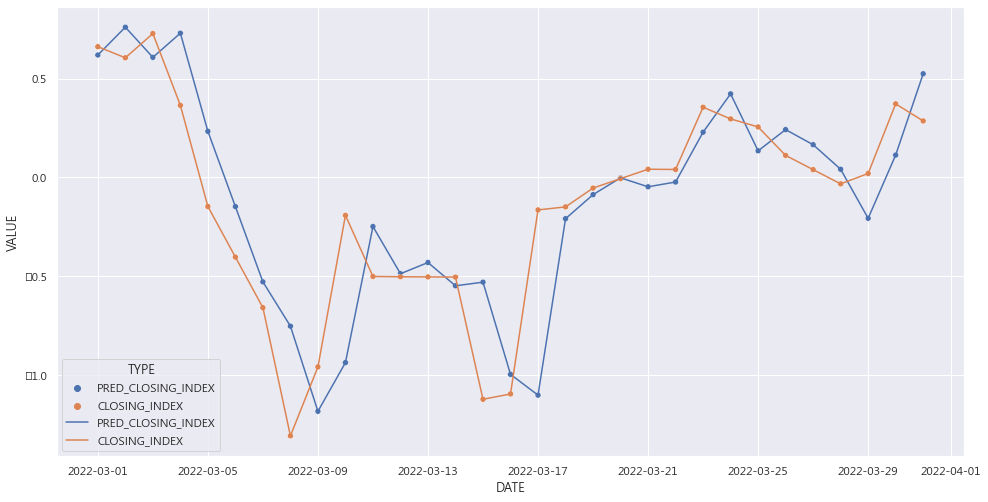

In [275]:
# 解釋方式
sns.set(rc={'figure.figsize':(16.27,8.27)})
sns.scatterplot(x='DATE', y='VALUE', data=plot_df, hue='TYPE')
sns.lineplot(x='DATE', y='VALUE', data=plot_df, hue='TYPE')

In [276]:
# Testing data performance
testing['PRED_CLOSING_INDEX'] = regressor.predict(testing[module1 + module6])
predict_df = testing[['PRED_CLOSING_INDEX', 'CLOSING_INDEX']]
predict_df.head(10)

PRED_CLOSING_INDEX  CLOSING_INDEX
DATE                                         
2022-04-01            0.133090       0.160717
2022-04-02            0.097782       0.066089
2022-04-03            0.149686       0.018775
2022-04-04           -0.067864      -0.004882
2022-04-05           -0.082855      -0.016710
2022-04-06            0.173341      -0.028539
2022-04-07           -0.105753      -0.659824
2022-04-08           -0.687853      -0.465392
2022-04-09           -0.413602      -0.682175
2022-04-10           -0.782514      -0.790567

In [278]:
stock_pricedf = stock_price.loc[stock_price['DATE'].apply(lambda x: '2021-10-01' <= x <= '2022-04-29')]
std = StandardScaler()
std.fit(stock_pricedf[['CLOSING_INDEX']])

StandardScaler()

In [281]:
predict_df[['INVERSE_COLSING']] = std.inverse_transform(predict_df[['CLOSING_INDEX']])
predict_df[['INVERSE_PRED_COLSING']] = std.inverse_transform(predict_df[['PRED_CLOSING_INDEX']])
predict_df

PRED_CLOSING_INDEX  CLOSING_INDEX  INVERSE_COLSING  \
DATE                                                             
2022-04-01            0.133090       0.160717     17625.590000   
2022-04-02            0.097782       0.066089     17574.045000   
2022-04-03            0.149686       0.018775     17548.272500   
2022-04-04           -0.067864      -0.004882     17535.386250   
2022-04-05           -0.082855      -0.016710     17528.943125   
2022-04-06            0.173341      -0.028539     17522.500000   
2022-04-07           -0.105753      -0.659824     17178.630000   
2022-04-08           -0.687853      -0.465392     17284.540000   
2022-04-09           -0.413602      -0.682175     17166.455000   
2022-04-10           -0.782514      -0.790567     17107.412500   
2022-04-11           -0.878819      -0.898958     17048.370000   
2022-04-12           -0.974437      -1.004445     16990.910000   
2022-04-13           -0.821464      -0.433981     17301.650000   
2022-04-14           -0.331552      -0.536787     17245.650000   
2022-04-15           -0.718347      -0.980084     17004.180000   
2022-04-16           -0.982484      -1.076749     16951.525000   
2022-04-17           -1.004191      -1.125082     16925.197500   
2022-04-18           -1.223254      -1.173414     16898.870000   
2022-04-19           -1.173809      -0.999874     16993.400000   
2022-04-20           -0.819220      -0.714440     17148.880000   
2022-04-21           -0.638922      -0.752863     17127.950000   
2022-04-22           -0.898903      -0.941696     17025.090000   
2022-04-23           -0.965220      -1.312708     16822.995000   
2022-04-24           -1.197479      -1.498213     16721.947500   
2022-04-25           -1.597842      -1.683719     16620.900000   
2022-04-26           -1.804459      -1.639861     16644.790000   
2022-04-27           -1.398582      -2.266685     16303.350000   
2022-04-28           -2.216584      -2.053674     16419.380000   
2022-04-29           -2.270601      -1.736444     16592.180000   

            INVERSE_PRED_COLSING  
DATE                              
2022-04-01          17610.541327  
2022-04-02          17591.308701  
2022-04-03          17619.581546  
2022-04-04          17501.078992  
2022-04-05          17492.913087  
2022-04-06          17632.466471  
2022-04-07          17480.440494  
2022-04-08          17163.362201  
2022-04-09          17312.750563  
2022-04-10          17111.798688  
2022-04-11          17059.340456  
2022-04-12          17007.255654  
2022-04-13          17090.582494  
2022-04-14          17357.444151  
2022-04-15          17146.751390  
2022-04-16          17002.872206  
2022-04-17          16991.048092  
2022-04-18          16871.721488  
2022-04-19          16898.654745  
2022-04-20          17091.804444  
2022-04-21          17190.015703  
2022-04-22          17048.400165  
2022-04-23          17012.276373  
2022-04-24          16885.761555  
2022-04-25          16667.678013  
2022-04-26          16555.130737  
2022-04-27          16776.218169  
2022-04-28          16330.640522  
2022-04-29          16301.216989

In [283]:
predict_df.to_csv('./data/predict_df.csv')

In [285]:
pip list

Package                  Version  
------------------------ ---------
anyio                    3.5.0    
argon2-cffi              21.3.0   
argon2-cffi-bindings     21.2.0   
argostranslate           1.6.1    
asttokens                2.0.5    
attrs                    21.4.0   
Babel                    2.9.1    
backcall                 0.2.0    
baidu-aip                4.16.3   
beautifulsoup4           4.10.0   
black                    22.1.0   
bleach                   4.1.0    
blis                     0.7.7    
bs4                      0.0.1    
cachetools               5.0.0    
catalogue                2.0.7    
certifi                  2021.10.8
cffi                     1.15.0   
chardet                  3.0.4    
charset-normalizer       2.0.11   
click                    8.0.3    
ctranslate2              2.10.1   
cycler                   0.11.0   
cymem                    2.0.6    
Cython                   0.29.28  
debugpy                  1.5.1    
decorator           